In [ ]:
#https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
#hdbscan offers range of built in visualisations but not so easy to use for analysis
#use euclidean distance as default, vary by parameters min_cluster_size, min_samples, cluster_selection_epsilon
#map clusterer results to detected cells and build graph database to traverse and inspect cluster tree

In [3]:
import pandas as pd
import numpy as np
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from qupath_filter_viz_functions import fiveDimStackedBar

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

In [4]:
data = pd.read_csv('test files/qupath_measures.csv')

In [5]:
rgb_data = data[['ratio_red', 'ratio_green', 'ratio_blue','ratio_cyan', 'ratio_orange']].to_numpy()
#rgb_data = data[['magnitude_red', 'magnitude_green','magnitude_blue', 'magnitude_cyan', 'magnitude_orange']].to_numpy()

In [6]:
#run hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            #min_samples=1,
                            cluster_selection_epsilon=0.035,
                            gen_min_span_tree=True)
clusterer.fit(rgb_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.035,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [7]:
#add cluster labels and probability
#cells returned as noice set to c_label == -1

label_dict = dict(zip(data['cell_index'],clusterer.labels_))
prob_dict = dict(zip(data['cell_index'],clusterer.probabilities_))

data['c_label'] = data['cell_index'].apply(lambda x:label_dict.get(x))
data['c_probability'] = data['cell_index'].apply(lambda x:prob_dict.get(x))

In [8]:
#save labelled data
#data.to_csv(r'test files\5_dim_hdb_result_epsilon.csv',index=False)

**WORKING WITH CLUSTERING DATA FUNCTIONALITY**

In [9]:
#return amount of noise and cluster labels ordered by size order
pivot = data.groupby('c_label').count().sort_values(by='cell_index',ascending=False)[['cell_index']]
index = [-1] + pivot.index.drop([-1]).tolist()
pivot = pivot.reindex(index)

In [10]:
pivot.head()

,cell_index
c_label,
-1,94
11,209
2,191
19,126
12,103


In [11]:
#transform clusterer output as df
clusterer_df = clusterer.condensed_tree_.to_pandas()

In [12]:
def addCellIndex(child,size):
    '''map cell_index from cell_detection df to child value in condensed_tree df'''
    
    if size == 1:
        cell_index = 'cell_'+str(child)
    else:
        cell_index = None
    
    return cell_index

#add cell index
clusterer_df['cell_index'] = clusterer_df[['child','child_size']].apply(lambda x:addCellIndex(*x),axis=1)

#map cell_index to selected cluster
model_output_cluster = dict(zip(data['cell_index'],data['c_label']))
clusterer_df['selected_cluster'] = clusterer_df['cell_index'].apply(lambda x:model_output_cluster.get(x))

In [13]:
#map selected_cluster to cluster_node in condensed tree  

tree_cluster = {}

for select_cluster in pivot.index[1:]:
    slice_df = clusterer_df[clusterer_df['selected_cluster']==select_cluster]
    cluster_node = slice_df['parent'].unique().min()
    
    tree_cluster[select_cluster] = cluster_node

clusterer_df['node_cluster'] = clusterer_df['selected_cluster'].apply(lambda x:tree_cluster.get(x))

In [14]:
#define and derive node classification in tree
#elements traverse from len(root_node) == 1 to len(single_cell_node+noise_node) == total number of cells

cluster_slice = clusterer_df[clusterer_df['child_size'] > 1]
single_cell_slice = clusterer_df[clusterer_df['child_size'] == 1]

selected_cluster_node = list(tree_cluster.values())
root_node = [clusterer_df['parent'].min()]
branch_node = list(set(cluster_slice['parent']).intersection(set(cluster_slice['child']))- set(selected_cluster_node))
leaf_node = list(set(cluster_slice['child']) - set(branch_node))
noise_node = list(set(clusterer_df[clusterer_df['selected_cluster']== -1]['child']))
single_cell_node = list(set(single_cell_slice['child'])- set(noise_node))

In [15]:
def genEdges(nodes,df): 
    '''return edges as list of tuples'''
    
    def tupleValues(x,y):
        return (x,y)
    
    def filterCells(x):
        if x in nodes:
            return 'Y'
    
    #filter clusterer_df by nodes and tuple(parent, child)
    df['inc_cell'] = df['child'].apply(lambda x:filterCells(x))
    
    df_slice = df[df['inc_cell'] == 'Y']
    edges = list(df_slice[['parent','child']].apply(lambda x:tupleValues(*x),axis=1))
    
    df = df.drop(columns='inc_cell')
    
    return edges,df

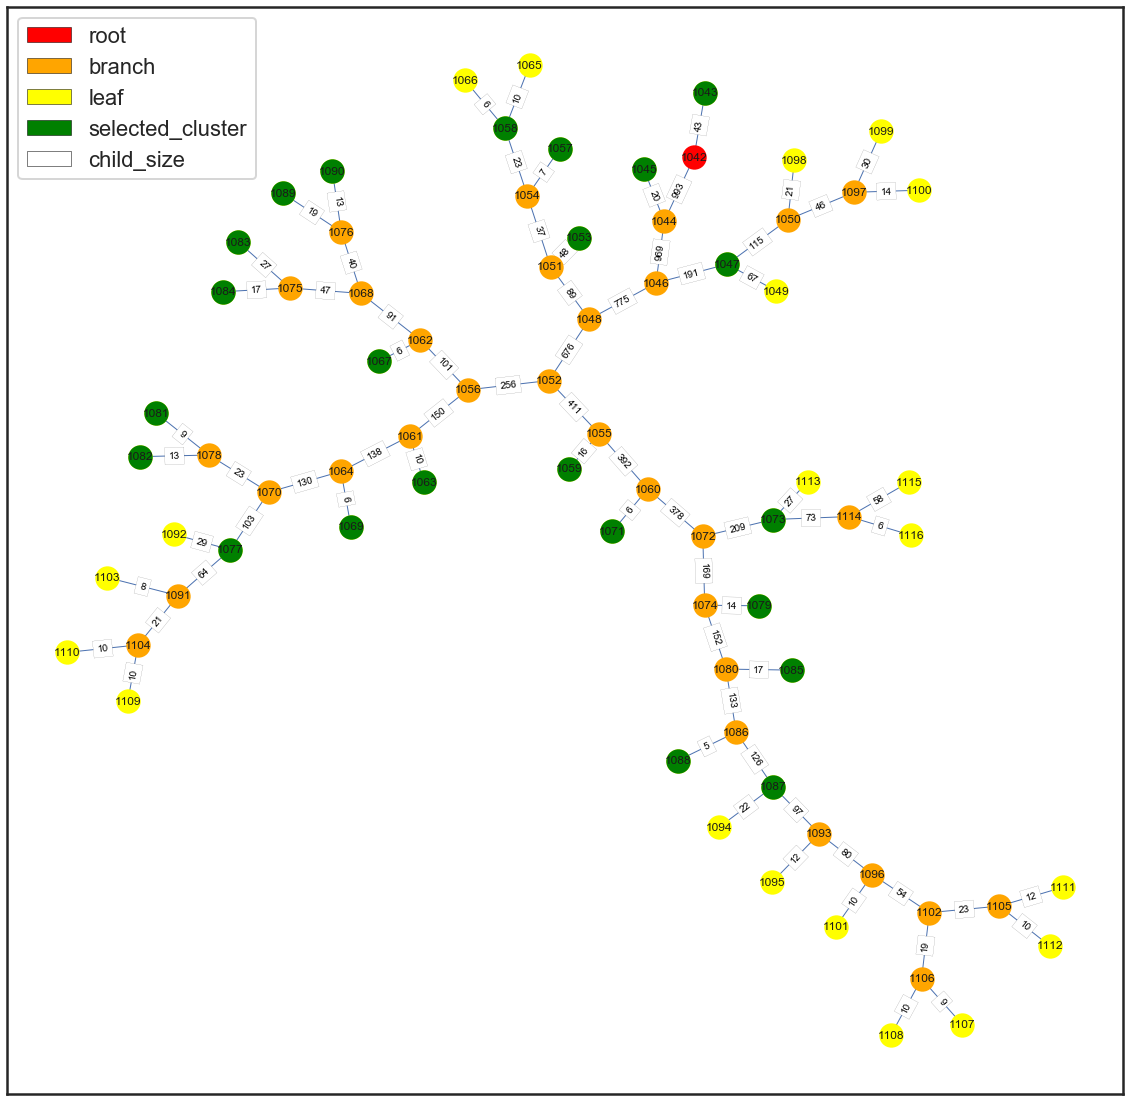

In [16]:
#generate networkx graph viz 
G = nx.Graph()

#declare nodes to be included in viz
nodes = root_node+branch_node+leaf_node+selected_cluster_node#+noise_node+single_cell_node
G.add_nodes_from(nodes)

#generate edges as list of tuples
edges,clusterer_df = genEdges(nodes,clusterer_df)

G.add_edges_from(edges)

plt.figure(figsize=(20,20))
pos = nx.kamada_kawai_layout(G)

#uncomment nodes to be included in viz
nx.draw_networkx_nodes(G, pos, nodelist = root_node, node_color = 'red', node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = branch_node, node_color = 'orange',node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = leaf_node, node_color = 'yellow', node_size = 500)
nx.draw_networkx_nodes(G, pos, nodelist = selected_cluster_node, node_color = 'green', node_size = 500)
#nx.draw_networkx_nodes(G, pos, nodelist = noise_node, node_color = 'grey',node_size = 500)
#nx.draw_networkx_nodes(G, pos, nodelist = single_cell_node,node_color = 'blue', node_size = 500)

nx.draw_networkx_edges(G, pos,edgelist=edges, edge_color='b')
nx.draw_networkx_labels(G, pos)

#add child_size of cluster as edge label
edge_child = list(map(lambda x:x[1], edges))
child_size_dict = dict(zip(clusterer_df['child'],clusterer_df['child_size']))
edge_child_size = list(map(lambda x:child_size_dict.get(x), edge_child))
egde_label = dict(zip(edges,edge_child_size))
nx.draw_networkx_edge_labels(G,pos,edge_labels=egde_label,font_color='black',bbox=dict(facecolor='white', edgecolor='black',linewidth= 0.1))

#uncomment node labels to be included in viz
red_patch = mpatches.Patch(facecolor='red', label='root',edgecolor='black',linewidth=0.5)
orange_patch = mpatches.Patch(facecolor='orange', label='branch',edgecolor='black',linewidth=0.5)
yellow_patch = mpatches.Patch(facecolor='yellow', label='leaf',edgecolor='black',linewidth=0.5)
green_patch = mpatches.Patch(facecolor='green', label='selected_cluster',edgecolor='black',linewidth=0.5)
#grey_patch = mpatches.Patch(facecolor='grey', label='noise',edgecolor='black',linewidth=0.5)
#blue_patch = mpatches.Patch(facecolor='blue', label='single_cell_node',edgecolor='black',linewidth=0.5)
white_patch = mpatches.Patch(facecolor='white', label='child_size',edgecolor='black',linewidth=0.5)
plt.legend(handles=[red_patch,
                    orange_patch,
                    yellow_patch,
                    green_patch,
                    #grey_patch,
                    #blue_patch
                    white_patch
                   ])

plt.show()

In [17]:
def extractNodeCells(node,df):
    '''return list of all cells by cell_index at given node'''
    
    #generate digraph
    DG = nx.DiGraph()

    #add all nodes to digraph
    nodes = root_node+branch_node+leaf_node+selected_cluster_node+noise_node+single_cell_node
    DG.add_nodes_from(nodes)
    
    #add all edges to digraph
    edges,df = genEdges(nodes,df)
    DG.add_edges_from(edges)
    
    #find all descendent nodes
    descendents = list(nx.nodes(nx.dfs_tree(DG, node)))[1:]

    single_cells = []

    #return cells from all descendent nodes as list
    for i in descendents:
        if df[df['child']==i].get('child_size').tolist() == [1]:
            single_cells.append(i) 
   
    #map child value to cell_index
    cell_index_dict = dict(zip(df['child'],df['cell_index']))
    
    def cellIndex(child):
        cell_index = cell_index_dict.get(child)
        return cell_index

    extract_cells = list(map(cellIndex, single_cells))
    
    return extract_cells

In [18]:
def nodeFilter(node,df):
    '''return input cell df with bool_column for channel analysis'''
    
    cells = extractNodeCells(node,clusterer_df)
    
    def inNode(x):
        if x in cells:
            return 'Y'
        else:
            return 'N'
        
    df['node_bool'] = df['cell_index'].apply(lambda x:inNode(x))
    
    return df

In [19]:
#return path of connecting nodes
path = list(nx.shortest_simple_paths(G,1055,1116))[0]

In [20]:
#sort data for viz
data = data.sort_values(by='ratio_red',ascending=False)

In [21]:
#iterate through path, return stacked bar of node cell channel ratio
for i in path:
    data = nodeFilter(i,data)
    #fiveDimStackedBar(data[data['node_bool']=='Y'],False,'node_bool')
    #print('^^ node '+str(i)+' ^^')

In [22]:
#or iterate through selected clusters
for i in selected_cluster_node:
    data = nodeFilter(i,data)
    #fiveDimStackedBar(data[data['node_bool']=='Y'],False,'node_bool')
    #print('^^ node '+str(i)+' ^^')

In [43]:
#currently using cell centroid as distance (um) as dimension rather than pixel coordinate 

def emptyMatrixViz(df):
    '''input list of tuple coordinates 
       return viz of empty matrix and coordinate cells as RGB square proportional to cell channel values'''

    #set min/max according to image size
    min_coord = 0
    max_coord = int(data[['centroid_x','centroid_y']].max().max())
    
    def centroidMinMax(coord):
        '''return slice values which will correspond to a single cell in numpy image matrix
           can change size of slice (cell size) according to number of cells and image size'''
    
        #set minimum dimension for cell size in image
        #minimum where centroid coordinate is min or max i.e. on edge of image
        #else cell dimension will be twice minimum dimension
        minimum_dimension = 3
    
        #check centroid coordinate is not on edge of image
        #if so, return min/max coordinate
        #else return slice as centroid coordinate +- minium_dimension
        if coord - minimum_dimension < min_coord:
            coord_low_lim = min_coord
        else:
            coord_low_lim = coord - minimum_dimension
        
        if coord + minimum_dimension > max_coord:
            coord_upper_lim = max_coord
        else:
            coord_upper_lim = coord + minimum_dimension
    
        return (int(coord_low_lim),int(coord_upper_lim))
    
    image = np.zeros((max_coord,max_coord,3), 'uint16')
    
    for i in df.index:
        x_limits,y_limits = centroidMinMax(int(df.loc[i].get('centroid_x'))),centroidMinMax(int(df.loc[i].get('centroid_y')))
    
        image[:,:,0][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = 255
        image[:,:,1][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = 255
        image[:,:,2][x_limits[0]:x_limits[1],y_limits[0]:y_limits[1]] = 255
    
    plt.figure(figsize=(12,12))
    
    return plt.imshow(image)

Loading BokehJS ...

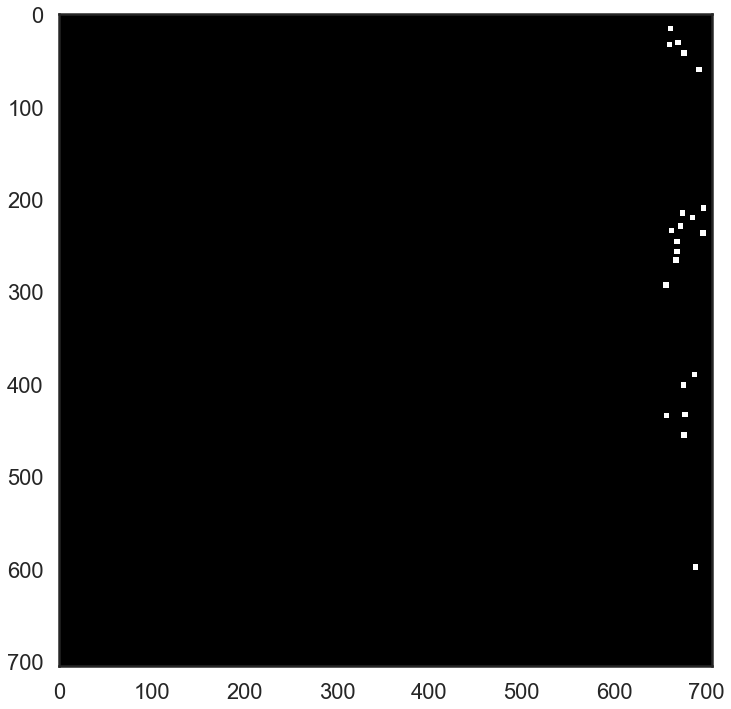

In [46]:
data = nodeFilter(1098,data)

fiveDimStackedBar(data[data['node_bool']=='Y'],False,'node_bool')

emptyMatrixViz(data[data['node_bool']=='Y'])